In [2]:
import numpy as np
from numpy.linalg import eigh
from matplotlib import pyplot as plt
import matplotlib
import tfim_1d
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10
api_token = input("Enter Token:")

In [3]:
num_sites = 4
J = 1.0
g = 4.0

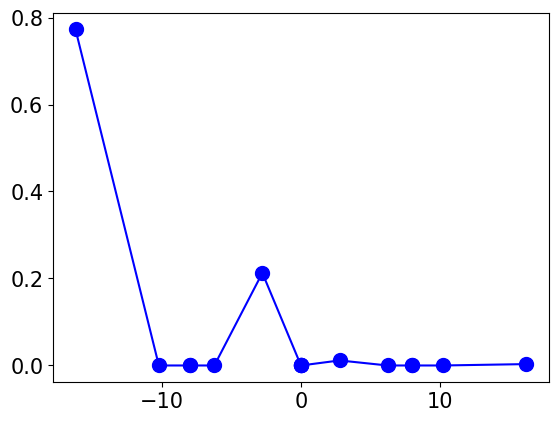

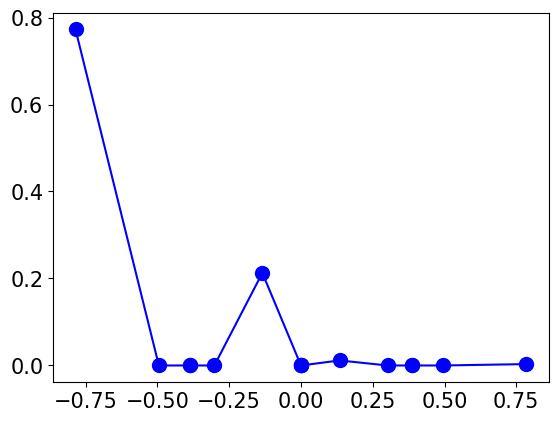

In [4]:
def modify_spectrum(ham):
    arr_ham = ham.toarray()
    arr_ham = arr_ham.astype(np.complex128)
    n = len(arr_ham[0])
    eigenenergies, _ = ham.eigh(subset_by_index = (n-1,n-1))
    max_eigenvalue = eigenenergies[0]
    norm_ham = (np.pi/4)*arr_ham/max_eigenvalue
    return norm_ham

# calculate the ground state with g = 1
ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()
old_ham = ham

# create modified spectrum
ham = modify_spectrum(old_ham)
eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [5]:
p0_array            = np.array([0.6,0.8]) # initial overlap with the first eigenvector
N_test              = 5 # number of comparisions each trial
Navg                = 1 # number of trials
err_threshold       = 0.01
T0                  = 100

# QCELS variables
T_list_QCELS        = 10+T0/2*(np.arange(N_test)) # circuit depth for QCELS
err_QCELS           = np.zeros((len(p0_array),N_test))
cost_list_avg_QCELS = np.zeros((len(p0_array),N_test))
rate_success_QCELS  = np.zeros((len(p0_array),N_test))
max_T_QCELS         = np.zeros((len(p0_array),N_test))

# QPE variables
T_list_QPE          = 10+T0*4*(np.arange(N_test)) # circuit depth for QPE
err_QPE             = np.zeros((len(p0_array),N_test))
cost_list_avg_QPE   = np.zeros((len(p0_array),N_test))
rate_success_QPE    = np.zeros((len(p0_array),N_test))


In [ ]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(N_test)
    n_success_QPE= np.zeros(N_test)
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(N_test):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = \
                    qcels_largeoverlap(spectrum, population, T, NT,
                            Nsample, lambda_prior)#QCELS with time T
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cosT_depth_list_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        print("N_try_QPE", N_try_QPE)
        for ix in range(N_test):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE) # uses dist with counts to get samp
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_ruN_test)
            if np.abs(err_this_ruN_test)<err_threshold:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Lin_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Lin_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Lin_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS
Re:  1.0 Im:  0.54
		 (1+0.08000000000000007j)
Re:  0.87 Im:  0.69
		 (0.74+0.3799999999999999j)
Re:  0.75 Im:  0.82
		 (0.5+0.6399999999999999j)
Re:  0.43 Im:  0.8
		 (-0.14+0.6000000000000001j)
Re:  0.39 Im:  0.56
		 (-0.21999999999999997+0.1200000000000001j)
	 [ 0.69295406 -0.03316966 -0.59374833]
Re:  1.0 Im:  0.47
		 (1-0.06000000000000005j)
Re:  0.73 Im:  0.86
		 (0.45999999999999996+0.72j)
Re:  0.32 Im:  0.64
		 (-0.36+0.28j)
Re:  0.72 Im:  0.31
		 (0.43999999999999995-0.38j)
Re:  0.87 Im:  0.56
		 (0.74+0.1200000000000001j)
	 [ 0.62325312 -0.21830769 -0.86119156]
END QCELS
START QCELS
Re:  1.0 Im:  0.54
		 (1+0.08000000000000007j)
Re:  0.82 Im:  0.76
		 (0.6399999999999999+0.52j)
Re:  0.5 Im:  0.76
		 0.52j
Re:  0.44 Im:  0.39
		 (-0.12-0.21999999999999997j)
Re:  0.53 Im:  0.26
		 (0.06000000000000005-0.48j)
	 [ 0.54763977 -0.12595845 -0.81345853]
Re:  1.0 Im:  0.53
		 (1+0.06000000000000005j)
Re:  0.44 Im:  0.8
		 (-0.12+0.6000000000000001

In [ ]:
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(N_test)
    n_success_QPE= np.zeros(N_test)
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(N_test):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = \
                    qcels_largeoverlap_ham(ham, T, NT, Nsample, lambda_prior)
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cosT_depth_list_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        print("N_try_QPE",N_try_QPE)
        for ix in range(N_test):
            T = int(T_list_QPE[ix])
            ground_energy_estimate_QPE = generate_QPE_sampling_ham(ham, Nsample, 2*T)
            print("ground_energy_estimate_QPE", ground_energy_estimate_QPE)
            err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_ruN_test)

            if np.abs(err_this_ruN_test)<err_threshold:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Q_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Q_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Q_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS


Re:  1.0 Im:  0.58
		 (1+0j)
Re:  0.82 Im:  0.79
		 (0.6399999999999999+0.7683749084919419j)
Re:  0.38 Im:  0.99
		 (-0.23999999999999996+0.9707728879609278j)
Re:  0.1 Im:  0.83
		 (-0.8+0.6j)
Re:  0.01 Im:  0.54
		 (-0.98+0.198997487421324j)
	 [ 0.98243194  0.12306621 -0.75063306]
Re:  1.0 Im:  0.54
		 (1+0j)
Re:  0.37 Im:  1.0
		 (-0.26000000000000006+0.9656086163658648j)
Re:  0.01 Im:  0.59
		 (-0.98+0.198997487421324j)
Re:  0.54 Im:  0
		 (0.07999999999999964-0.996794863550169j)
Re:  0.99 Im:  0.4
		 (0.98-0.19899748742132412j)
	 [ 0.98245286  0.10335922 -0.75626473]
END QCELS
START QCELS
Re:  1.0 Im:  0.44
		 (1-2.4492935982947064e-16j)
Re:  0.68 Im:  0.94
		 (0.3600000000000002+0.932952303175248j)
Re:  0.21 Im:  0.87
		 (-0.5800000000000002+0.814616474176652j)
Re:  0.09 Im:  0.31
		 (-0.8200000000000003-0.5723635208501671j)
Re:  0.42 Im:  0.02
		 (-0.16000000000000056-0.9871170143402452j)
	 [ 0.99020593  0.00851269 -0.77665525]
Re:  1.0 Im:  0.48
		 (1-2.4492935982947064e-16j)
Re

KeyboardInterrupt: 

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/general/general', token = api_token)
backend = service.backend('ibm_rensselaer')


for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    n_success_QCELS= np.zeros(N_test)
    n_success_QPE= np.zeros(N_test)
    for n_test in range(Navg):
        print("For p0=",p0,"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population(eigenenergies, 
                population_raw, [p0])
        #------------------QCELS-----------------
        Nsample=100 #number of samples for constructing the loss function
        for ix in range(N_test):
            T = T_list_QCELS[ix]
            NT = 5
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = \
                    run_qcels_largeoverlap(backend, ham, T, NT, Nsample, lambda_prior)
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cosT_depth_list_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[ix]+=1

       # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        print("N_try_QPE",N_try_QPE)
        for ix in range(N_test):
            T = int(T_list_QPE[ix])
            ground_energy_estimate_QPE = generate_QPE_sampling_ham(ham, Nsample, 2*T)
            print("ground_energy_estimate_QPE", ground_energy_estimate_QPE)
            err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_ruN_test)

            if np.abs(err_this_ruN_test)<err_threshold:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
np.savez('Data/Q_Sim_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/Q_Sim_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/Q_Sim_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

For p0= 0.6 For N_test= 1
START QCELS


KeyboardInterrupt: 